<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo07-vision-transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers

Transformers are an architecture used for sequence-to-sequence tasks. Historically, transformers have been used for natural language processing. However, because text requires lots of overhead to encode, we'll be working with transformers on images.

## Self-Attention
The defining part of transformer architectures is an operation called self-attention. Suppose the input to self-attention is the sequence of *tokens* $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^m$ and the output is the sequence $\mathbf{y}_1, \ldots, \mathbf{y}_n \in \mathbb{R}^m$.

The self-attention operation builds the output tokens by *combining* the input tokens. At a basic level,

$$\mathbf{y}_i = \sum_{j=1}^n (\mathbf{x}_i^\top \mathbf{x}_j) \mathbf{x}_j. $$

In this way, $\mathbf{y}_i$ will have larger components of input tokens its similar to.

If you look closely, you'll notice that the input tokens appear three times in the definition of the outputs: once as a "query" for similarity, once as a "key" for similarity, and once as a "value" to build the output. When we run self-attention, we define pass each appearance of the intput through its own fully connected layer.

Formally, we define the query vector $$\mathbf{q}_i = \mathbf{W}^{\textrm{query}} \mathbf{x}_i$$ for trainable weights $\mathbf{W}^\textrm{query}$, we define the key vector $$\mathbf{k}_i = \mathbf{W}^\textrm{key} \mathbf{x}_i$$ for trainable weights $\mathbf{W}^\textrm{key}$, and the value vector $$\mathbf{v}_i = \mathbf{W}^\textrm{value} \mathbf{x}_i$$ for trainable weights $\mathbf{W}^\textrm{value}$.
Then the self-attention operation is

$$\mathbf{y}_i = \sum_{j=1}^n (\mathbf{q}_i^\top \mathbf{k}_j) \cdot \mathbf{v}_j.$$

Notice that the basic and full self-attention operations are the same when all the weights are the identity matrices.


## Making Transformers Visual

Transformers were introduced in the popular paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). For the first three years, they were primarily used for natural language processing tasks. Part of the reason is that it wasn't clear how to encode images into sequences or use a sequence output for classification. Another part of the reason is that vision transformers seem to need more compute and data than convolutional networks. (Check out [this](https://www.reddit.com/r/MachineLearning/comments/lh7iwp/d_why_did_it_took_3_years_to_use_transformers_in/) thread for more discussion.)

A technique for using transformers on vision tasks was popularized in the paper [An Image is Worth 16x16 words](https://arxiv.org/abs/2010.11929). Like the catchy title suggests, the paper turns an image into a sequence by partitioning the image into equally sized patches. They also turned the output sequence into a class prediction by adding a dummy class embedding token to the sequence and applying a final fully connected layer to it.

![](https://production-media.paperswithcode.com/social-images/UhPqfdxgjZGSAsbC.png)

It's possible to train a simple vision transformer (see the old demo [here](https://github.com/rtealwitter/dl-demos/blob/5c997bb7b90eca6881140dea6bb85cf0ecd623a8/extra/visual_transformers.ipynb)). But today, we'll use a very large pretrained vision transformer that we won't be train.


In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


We can speed up computation by putting our data and models onto a GPU. So that the code won't break if we don't have a GPU, we'll define the device depending on the resources we have.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The vision transformer we'll use today was trained on the ImageNet dataset. Instead of loading ImageNet, we'll use the smaller Caltech101 dataset. (You can see all of the easy-to-load datasets that PyTorch offers [here](https://pytorch.org/vision/main/datasets.html).)

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
])

data = {
    split : torchvision.datasets.Caltech101(
        root = 'data', target_type = 'category',
        transform = data_transforms,
        download = True)
    for split in ['train', 'val']
}

data_loaders = {
    split : torch.utils.data.DataLoader(data[split], batch_size=16, shuffle=True)
    for split in ['train', 'val']
}

131740031it [00:04, 29413712.56it/s]


Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


14028800it [00:00, 28865939.12it/s]


Extracting data/caltech101/Annotations.tar to data/caltech101
Files already downloaded and verified


Let's take a look at the Caltech101 dataset.

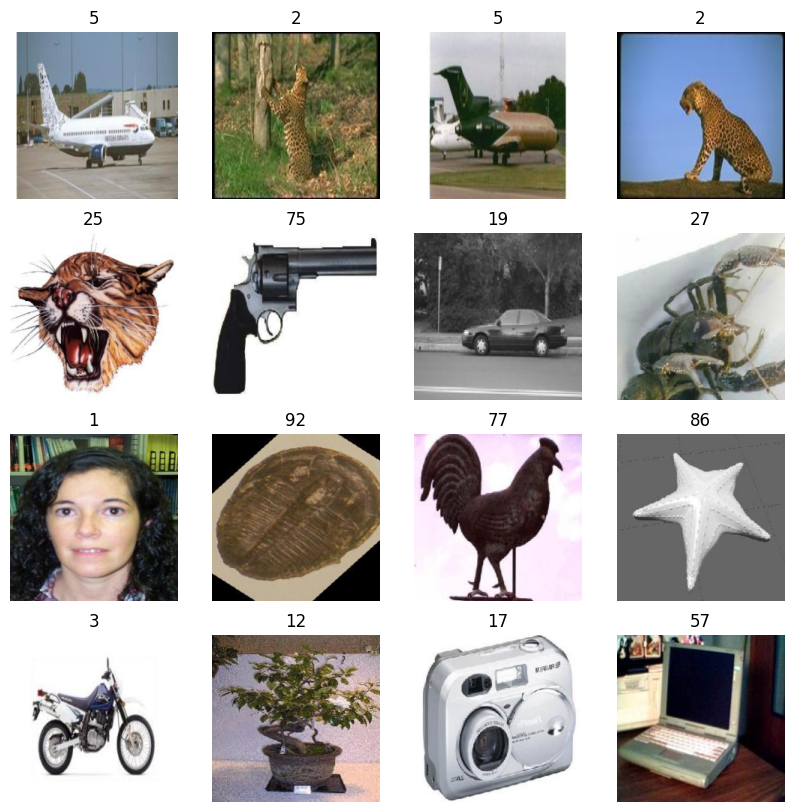

In [4]:
images, labels = next(iter(data_loaders['train']))

def plot(images, labels, nrows=4, ncols=4):
  fig, axes = plt.subplots(nrows, ncols, figsize=(10,10))
  idx = 0
  for i in range(nrows):
    for j in range(ncols):
      ax = axes[i,j]
      ax.imshow(images[idx].cpu().permute(1,2,0))
      label = labels[idx]
      # Handles tensor labels
      if type(labels[idx]) == torch.Tensor:
        label = label.cpu().item()
      # Handles text labels separated with commas
      else:
        splitted = label.split(',')
        if len(splitted) > 1:
          print(label)
          label = splitted[0]
      ax.set_title(label)
      ax.axis('off')
      idx += 1
  plt.show()

plot(images, labels)

The 101 labels in the Caltech101 dataset do not correspond to the 1000 labels in the ImageNet dataset. So we'll load the text description of the 1000 ImageNet labels from a handy textfile [here](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [5]:
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
from urllib.request import urlopen
imagenet_class_to_name = {}
for line in urlopen(url).readlines():
  line = str(line)[3:-4].replace("'", '') # Please don't judge me
  number, description = line.split(": ")
  imagenet_class_to_name[int(number)] = description

Now that we have our data and a way to interpret the model, let's load the model with pretrained weights!

In [6]:
model = torchvision.models.vit_b_16(weights='DEFAULT').eval()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:08<00:00, 43.2MB/s]


Let's print our model to see what's going on.

In [7]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

The model has a series of encoder layers with self-attention operations. The final layer consists of applying a fully connected layer to one of the output sequences.

For fun, let's count the number of parameters.

In [8]:
num_param = sum([p.numel() for p in model.parameters()])
print(f"There are {num_param} parameters in the model!")

There are 86567656 parameters in the model!


Training this model for any reasonable length of time is difficult given our resources. So we'll evaluate what it's doing on the Caltech101 dataset.

In [9]:
# We'll put the model and the data on the GPU (if we have one) for faster computation
model = model.to(device)
images = images.to(device)

output = model(images)

Let's take a look at the output.

In [10]:
output.shape # (num_batches, output_length)

torch.Size([16, 1000])

The output length is the number of classes. We'll take the classes with the highest values and then convert them to text description with our `imagenet_class_to_name` dictionary.

In [11]:
values, indices = output.max(axis=1)
predicted_labels = [imagenet_class_to_name[idx.item()] for idx in indices]

Now we can plot the images and their labels.

leopard, Panthera pardus
warplane, military plane
leopard, Panthera pardus
tiger, Panthera tigris
revolver, six-gun, six-shooter
crayfish, crawfish, crawdad, crawdaddy
bookshop, bookstore, bookstall
starfish, sea star
pot, flowerpot
notebook, notebook computer


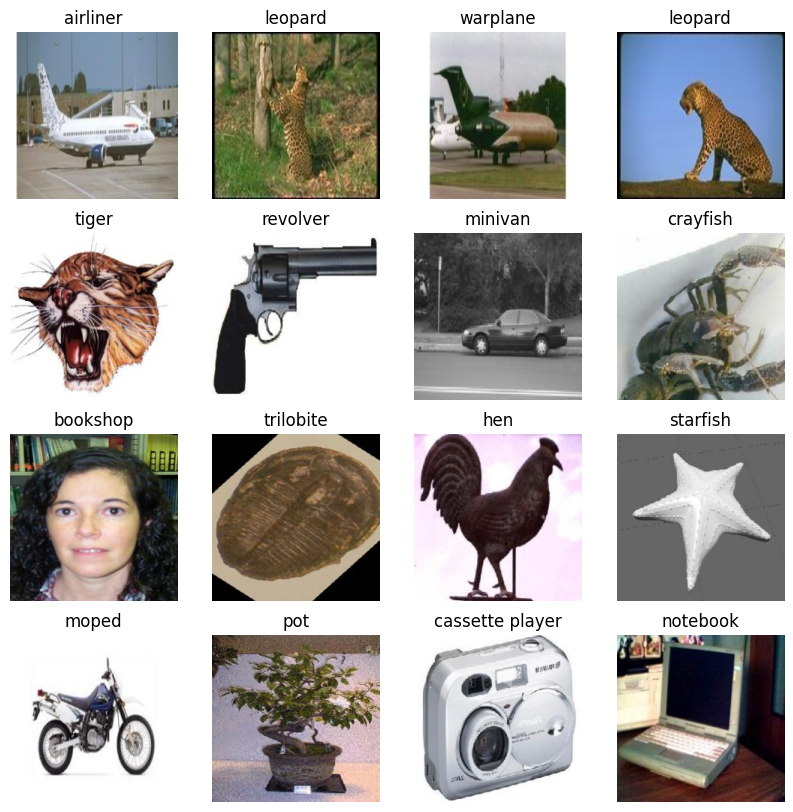

In [12]:
plot(images, predicted_labels)

There are some errors because the class labels of ImageNet are not a super set of the Caltech101 labels. Nonetheless, there are some impressive predictions!

One of the coolest things about transformers is visualizing the similarity between the different tokens in the sequence.

We'll dig into the [depths](https://pytorch.org/vision/main/_modules/torchvision/models/vision_transformer.html#vit_b_16) of the model forward pass to expose the internal self-attention.

In [13]:
# Forward pass through the VisionTransformer class defined here: https://pytorch.org/vision/main/_modules/torchvision/models/vision_transformer.html#vit_b_16
x = model._process_input(images)

# Add a dummy token for classification
n = x.shape[0]
batch_class_token = model.class_token.expand(n, -1, -1)
x = torch.cat([batch_class_token, x], dim=1)

y = model.encoder(x) # Takes the most time
y = y[:,0]
y = model.heads(y)

Recall that the self-attention operation resides in the layers of the encoder. We'll use `x` and only pass it through the first self-attention layer. First, we'll take a look at the dimension of `x`.

In [14]:
x.shape # (batch_size, num_tokens, token_dimension)

torch.Size([16, 197, 768])

In [15]:
z = model.encoder.layers.encoder_layer_0.ln_1(x) # LayerNorm
# z serves as the keys, values, and queries to self-attention
z, weights = model.encoder.layers.encoder_layer_0.self_attention(z, z, z, need_weights=True)
weights.shape # (batch_size, num_tokens, num_tokens)

torch.Size([16, 197, 197])

The weights contain the similarity between each token. We'll visualize weights for the dummy classification token. This means extracting the first row of the weights matrix, ignoring the first value (similarity between classification)

In [16]:
classification_weights = weights[:,0,1:].reshape(-1, 14,14)

Now we can visualize the classification weights with the original image.

leopard, Panthera pardus
warplane, military plane
leopard, Panthera pardus
tiger, Panthera tigris
revolver, six-gun, six-shooter
crayfish, crawfish, crawdad, crawdaddy


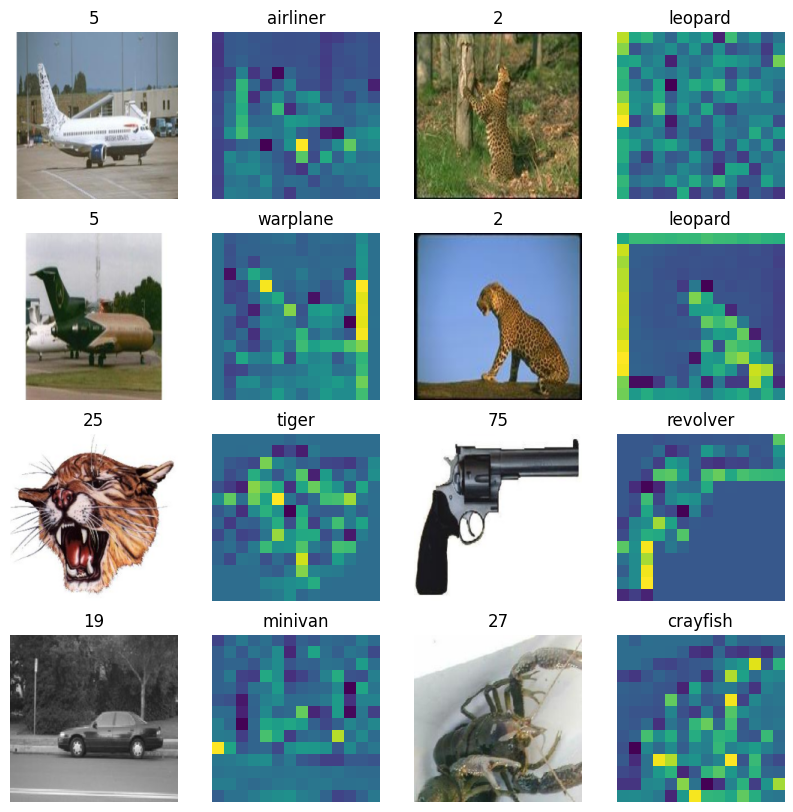

In [17]:
def plot_with_weights(images, classification_weights, labels, pred_labels, nrows=4, ncols=2):
  fig, axes = plt.subplots(nrows, 2*ncols, figsize=(10,10))
  idx = 0
  for i in range(nrows):
    for j in range(ncols):
      # Label
      label = labels[idx].cpu().item()
      pred_label = pred_labels[idx]
      splitted = pred_label.split(',')
      if len(splitted) > 1:
        print(pred_label)
        pred_label = splitted[0]

      # Image
      ax = axes[i,2*j]
      ax.imshow(images[idx].cpu().permute(1,2,0))
      ax.set_title(label)
      ax.axis('off')

      # Classification weights
      ax = axes[i,2*j+1]
      ax.imshow(classification_weights[idx].cpu().detach().numpy())
      ax.set_title(pred_label)
      ax.axis('off')
      idx += 1
  plt.show()

plot_with_weights(images, classification_weights, labels, predicted_labels)

These are almost recognizable! Let's take a look for the representation at later layers.

In [18]:
# Pass through first 10 layers
z = model.encoder.layers.encoder_layer_0(x)
z = model.encoder.layers.encoder_layer_1(z)
z = model.encoder.layers.encoder_layer_2(z)
z = model.encoder.layers.encoder_layer_3(z)
z = model.encoder.layers.encoder_layer_4(z)
z = model.encoder.layers.encoder_layer_5(z)
z = model.encoder.layers.encoder_layer_6(z)
z = model.encoder.layers.encoder_layer_7(z)
z = model.encoder.layers.encoder_layer_8(z)
z = model.encoder.layers.encoder_layer_9(z)
z = model.encoder.layers.encoder_layer_10(z)

z = model.encoder.layers.encoder_layer_11.ln_1(x) # LayerNorm
# z serves as the keys, values, and queries to self-attention
z, weights = model.encoder.layers.encoder_layer_11.self_attention(z, z, z, need_weights=True)
weights.shape # (batch_size, num_tokens, num_tokens

torch.Size([16, 197, 197])

We'll now extract the classification weights from the last encoder layer.

In [19]:
classification_weights = weights[:,0,1:].reshape(-1, 14,14)

And we can plot the classification weights against the initial image.

leopard, Panthera pardus
warplane, military plane
leopard, Panthera pardus
tiger, Panthera tigris
revolver, six-gun, six-shooter
crayfish, crawfish, crawdad, crawdaddy


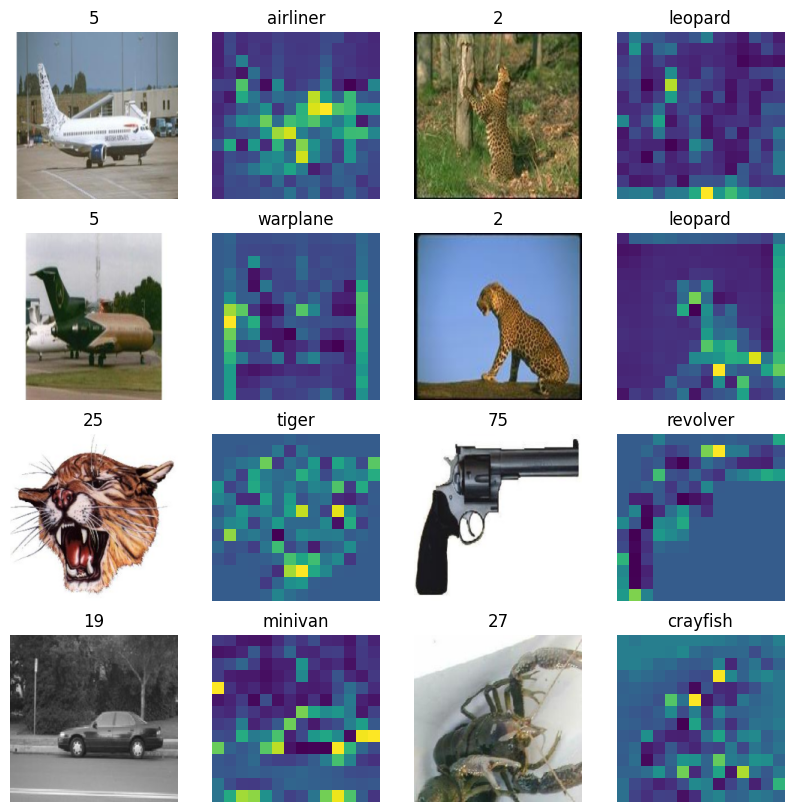

In [20]:
plot_with_weights(images, classification_weights, labels, predicted_labels)

For some images, the classification weights look the same. However, for other images, the classification weights are more defined and conform to the object more closely.